In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import layers,models

In [2]:
# Defining Regularized loss function
def regloss(y_pred,y,w1,w2=0):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    loss=(1/(batch_size))*(np.square(y-y_pred)).sum()+reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [3]:
# Defining accuracy function
def accuracy(y_pred,y):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    #acc=1-(1/(batch_size))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [70]:
# definng the function to plot the analytics
def graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,name,compare=False,n=2,labels=[]):
    lists=[loss_history,loss_history_test,train_acc_history,val_acc_history]
    titiles=["training loss","testing loss","training accuracy","testing accuracy"]
    fig,ax=plt.subplots(1,4,figsize=(25,5))
    for i in range(len(lists)):
        if compare:
            for j in range(n):
                ax[i].plot(lists[i][j],label=labels[j])
            ax[i].legend()  
        else:
            ax[i].plot(lists[i])
        ax[i].set_ylabel(titiles[i])
        ax[i].set_xlabel("epoch")
        ax[i].plot()
    fig.savefig(fname="metrics_"+name+".png",transparent=True)
    return True

In [54]:
# Defining function for data preprocessing
def preproc(norm,reshape):
    # Importing data set
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    K = len(np.unique(y_train)) # Classes #np.unique Find the unique elements of an array.
    Ntr = x_train.shape[0] # Number of training data
    Nte = x_test.shape[0] # Number of testing data
    Din = x_train.shape[1]*x_train.shape[2]*x_train.shape[3] # CIFAR10

    if norm:
        # Normalize pixel values
        x_train, x_test = x_train / 255.0, x_test / 255.0

    # Centering pixel values
    mean_image = np.mean(x_train, axis=0)
    x_train = x_train - mean_image
    x_test = x_test - mean_image

    # One hot encoding the labels
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

    #flatterning the input images and changing the data type
    if reshape:
        x_train = np.reshape(x_train,(Ntr,Din))
        x_test = np.reshape(x_test,(Nte,Din))
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('x_train:', x_train.shape)
    print('x_test:', x_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)
    return x_train,y_train,x_test,y_test

# Linear Classifier

In [9]:
# Defining linear Classifier function

def linclas(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0] # Number of training data
    Nte = x_test.shape[0] # Number of testing data

    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    # Initializing weight and bias arrays
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    for t in range(iterations):
        # shuffling the training data set to randomize the training process.To prevent overfitting
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        # forward pass
        y_pred=x.dot(w1)+b1
        y_pred_test=x_test.dot(w1)+b1

        # calculating loss
        train_loss=regloss(y_pred,y,w1)
        test_loss=regloss(y_pred_test,y_test,w1)
        loss_history.append(train_loss)
        loss_history_test.append(test_loss)
        
        # calculating accuracy
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: loss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw1=x.T.dot(dy_pred)+reg*w1
        db1=dy_pred.sum(axis=0)

        # updating parameters
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history

In [49]:
x_train,y_train,x_test,y_test=preproc(True)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)


In [10]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda
w1,b1,loss_history,loss_history_test,train_acc_history,val_acc_history=linclas(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

epoch 0/300: loss= 0.999977-- ,test loss= 0.999973--,train accracy= 0.681550--, test accracy= 0.681780
epoch 10/300: loss= 0.876637-- ,test loss= 0.876236--,train accracy= 0.756426--, test accracy= 0.758020
epoch 20/300: loss= 0.842541-- ,test loss= 0.842417--,train accracy= 0.762644--, test accracy= 0.767820
epoch 30/300: loss= 0.823617-- ,test loss= 0.823715--,train accracy= 0.766510--, test accracy= 0.770480
epoch 40/300: loss= 0.812389-- ,test loss= 0.812707--,train accracy= 0.768606--, test accracy= 0.771610
epoch 50/300: loss= 0.805426-- ,test loss= 0.805970--,train accracy= 0.770424--, test accracy= 0.772820
epoch 60/300: loss= 0.800906-- ,test loss= 0.801679--,train accracy= 0.771590--, test accracy= 0.773650
epoch 70/300: loss= 0.797822-- ,test loss= 0.798824--,train accracy= 0.772696--, test accracy= 0.773580
epoch 80/300: loss= 0.795605-- ,test loss= 0.796835--,train accracy= 0.773772--, test accracy= 0.774410
epoch 90/300: loss= 0.793930-- ,test loss= 0.795381--,train accra

True

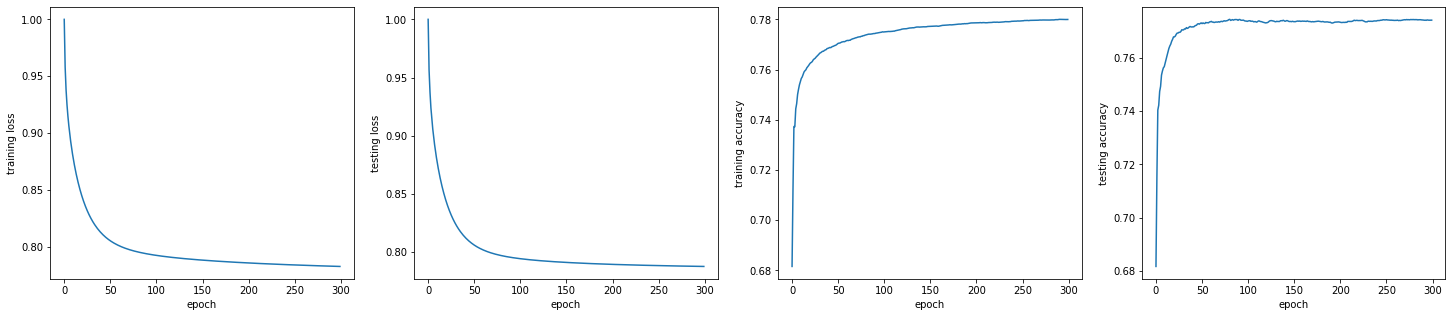

In [39]:
# ploting metrics
graphs(loss_history,loss_history_test,train_acc_history,val_acc_history,"linear classifier")

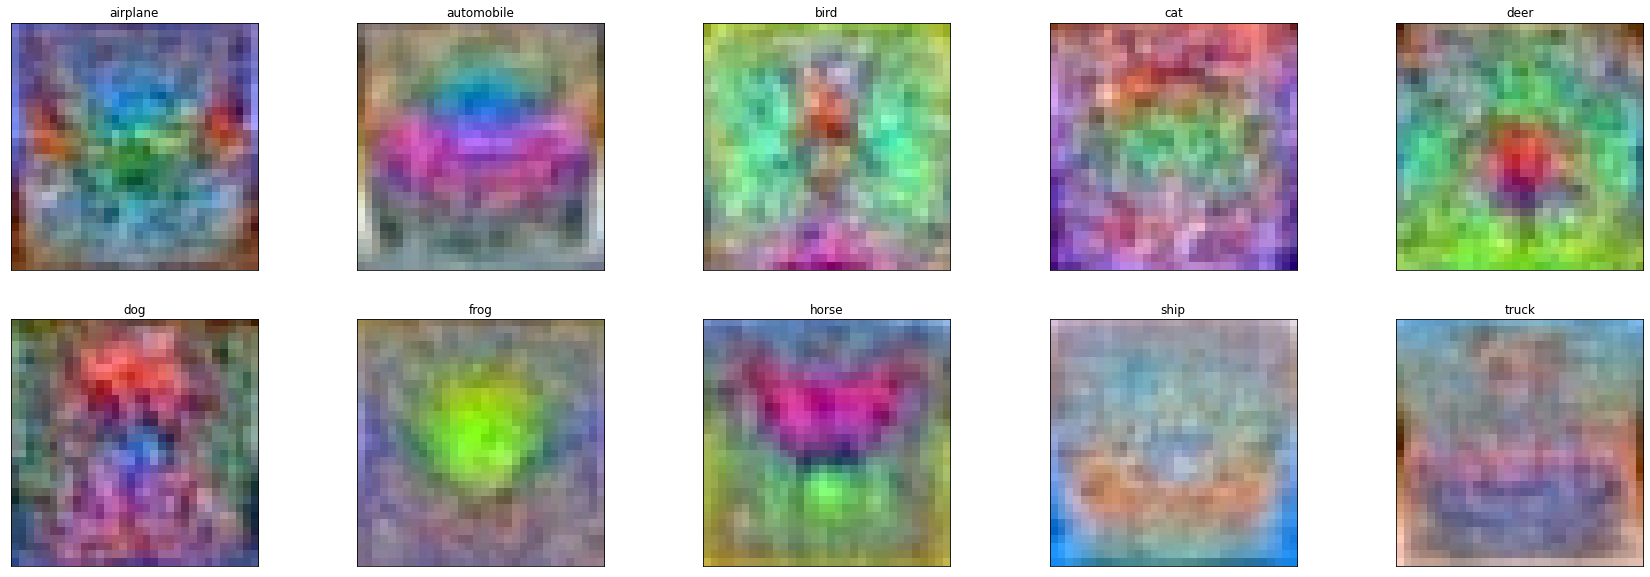

In [46]:
images=[]
titles=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for i in range(w1.shape[1]):
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(titles[i*5+j])
plt.show()
fig.savefig("w1_images.png",transparent=True)

# 2 Layer Dense Network

In [51]:
def layer2(x_train,y_train,x_test,y_test,batch_size,H,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    loss_history_test = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    #initializing weight and bias arrays
    std=1e-5
    w1 = (2/(Ntr*Din))**0.5*np.random.randn(Din, H)
    w2 = (2/(H*Din))**0.5*np.random.randn(H, K)
    b1 = np.zeros(H)
    b2 = np.zeros(K)

    for t in range(iterations):
        # mini batching the training data set
        indices = np.random.choice(Ntr,batch_size)
        # shuffling the training data set to avoid overfitting
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]

        #forward pass
        h=1/(1+np.exp(-(x.dot(w1)+b1)))
        h_test=1/(1+np.exp(-((x_test).dot(w1)+b1)))
        y_pred=h.dot(w2)+b2
        y_pred_test=h_test.dot(w2)+b2

        # calculating the loss
        train_loss=regloss(y_pred,y,w1,w2)
        test_loss=regloss(y_pred_test,y_test,w1,w2)
        loss_history.append(train_loss)
        loss_history_test.append(test_loss)
        
        # calculating accuracy
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)

        if t%10 == 0:
            print('epoch %d/%d: loss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2=h.T.dot(dy_pred)+reg*w2
        db2=dy_pred.sum(axis=0)
        dh=dy_pred.dot(w2.T)
        dw1=x.T.dot(dh*h*(1-h))+reg*w1
        db1=(dh*h*(1-h)).sum(axis=0)

        # updating parameters
        w1-=lr*dw1
        b1-=lr*db1
        w2-=lr*dw2
        b2-=lr*db2
        lr*=lr_decay
    return w1,b1,w2,b2,loss_history,loss_history_test,train_acc_history,val_acc_history

In [55]:
batch_size = Ntr
H=200
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda

x_trainn,y_trainn,x_testn,y_testn=preproc(norm=False,reshape=True)
w1n,b1n,w2n,b2n,loss_historyn,loss_history_testn,train_acc_historyn,val_acc_historyn=layer2(x_trainn,y_trainn,x_testn,y_testn,batch_size,H,K,Din,lr,lr_decay,reg)

x_train: (50000, 3072)
x_test: (10000, 3072)
y_train: (50000, 10)
y_test: (10000, 10)
epoch 0/300: loss= 0.997645-- ,test loss= 0.997634--,train accracy= 0.714706--, test accracy= 0.714720
epoch 10/300: loss= 0.824286-- ,test loss= 0.824257--,train accracy= 0.754768--, test accracy= 0.756020
epoch 20/300: loss= 0.810487-- ,test loss= 0.812218--,train accracy= 0.760246--, test accracy= 0.762920
epoch 30/300: loss= 0.801661-- ,test loss= 0.802897--,train accracy= 0.767460--, test accracy= 0.766380
epoch 40/300: loss= 0.791237-- ,test loss= 0.793593--,train accracy= 0.772666--, test accracy= 0.774910
epoch 50/300: loss= 0.791589-- ,test loss= 0.793126--,train accracy= 0.769102--, test accracy= 0.770380
epoch 60/300: loss= 0.783442-- ,test loss= 0.787037--,train accracy= 0.772882--, test accracy= 0.774110
epoch 70/300: loss= 0.794412-- ,test loss= 0.798341--,train accracy= 0.775398--, test accracy= 0.769830
epoch 80/300: loss= 0.771803-- ,test loss= 0.778255--,train accracy= 0.781758--, te

True

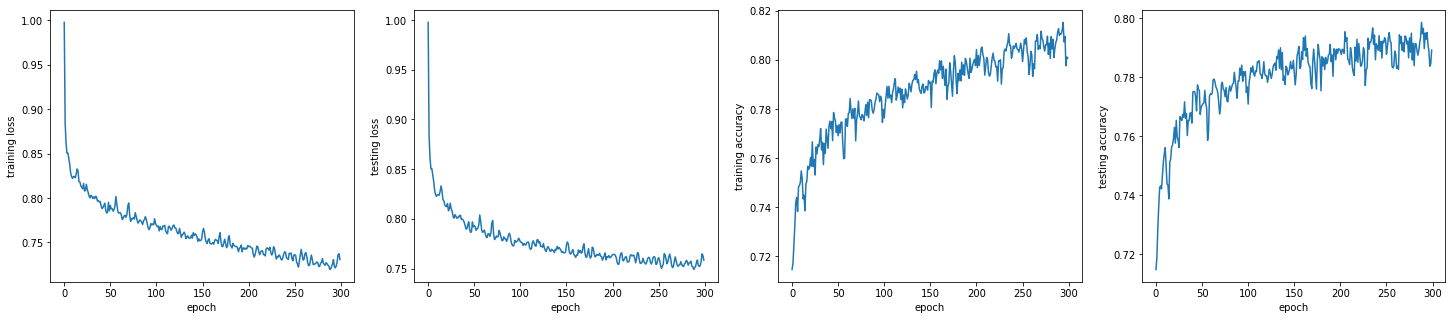

In [56]:
graphs(loss_historyn,loss_history_testn,train_acc_historyn,val_acc_historyn,"2 layer dense")

# With batching

In [57]:
batch_size = 500
H=200
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6 #lamda

w1m,b1m,w2m,b2m,loss_historym,loss_history_testm,train_acc_historym,val_acc_historym=layer2(x_trainn,y_trainn,x_testn,y_testn,batch_size,H,K,Din,lr,lr_decay,reg)

epoch 0/300: loss= 0.993835-- ,test loss= 0.993658--,train accracy= 0.727800--, test accracy= 0.729970
epoch 10/300: loss= 0.832154-- ,test loss= 0.840175--,train accracy= 0.768000--, test accracy= 0.742990
epoch 20/300: loss= 0.829207-- ,test loss= 0.827494--,train accracy= 0.734600--, test accracy= 0.746540
epoch 30/300: loss= 0.800819-- ,test loss= 0.809257--,train accracy= 0.765400--, test accracy= 0.755410
epoch 40/300: loss= 0.818379-- ,test loss= 0.804550--,train accracy= 0.744200--, test accracy= 0.759160
epoch 50/300: loss= 0.803765-- ,test loss= 0.804415--,train accracy= 0.772400--, test accracy= 0.759730
epoch 60/300: loss= 0.806721-- ,test loss= 0.795618--,train accracy= 0.769000--, test accracy= 0.778220
epoch 70/300: loss= 0.797239-- ,test loss= 0.794664--,train accracy= 0.761400--, test accracy= 0.764090
epoch 80/300: loss= 0.769360-- ,test loss= 0.789237--,train accracy= 0.782000--, test accracy= 0.767890
epoch 90/300: loss= 0.801574-- ,test loss= 0.794224--,train accra

True

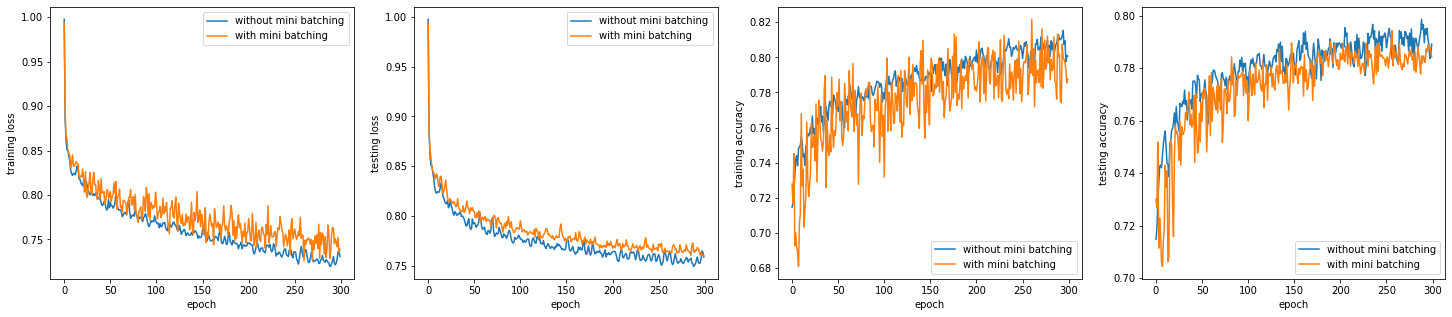

In [72]:
graphs([loss_historyn,loss_historym],[loss_history_testn,loss_history_testm],[train_acc_historyn,train_acc_historym],[val_acc_historyn,val_acc_historym],"2 layer dense with mini batching",compare=True,n=2,labels=["without mini batching","with mini batching"])

# CNN

In [73]:
x_trainc,y_trainc,x_testc,y_testc=preproc(norm=False,reshape=False)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)


In [63]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

model.summary()

model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
model.fit(x_trainc,y_trainc,epochs=60,batch_size=50)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)             